# Read file Y_FUNC.txt

This file was copied from the output of TensErLEED and contains the actual used Y function for a Cu(111) test system

In [1]:
from cmath import exp
from re import S
from unicodedata import name
import numpy as np
import time
import timeit  # dependency for testing! Don't use in Viperleed build
from scipy.optimize import curve_fit
import random
import os

import matplotlib
#matplotlib.rcParams.update({'figure.max_open_warning': 0})
#matplotlib.use('Agg')  # !!! check with Michele if this causes conflicts
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker


In [72]:
exp = []
theo = []
xy = []

with open("verification_data/Hematite2x1/Hematite2x1_TensErLEED_beams.txt", "r") as file:
    
    # read exp
    line = file.readline()
    while not line.startswith(" PENDRY Y"):
        line = file.readline()
        
    print('start exp')
    while True:
        line = file.readline()
        if line.startswith(" PENDRY Y"):
            exp.append(np.copy(np.array(xy)))
            xy = []
        elif line == "" or line.startswith("*Hematite 2"):
            exp.append(np.copy(np.array(xy)))
            break
        else:
            parts = line.split()
            while len(parts) > 0:
                xy.append([float(parts.pop(0)), float(parts.pop(0))])
        continue
        # end read exp
        
    # read intermittend stuff        
    while not line.startswith(" PENDRY Y"):
        line = file.readline()

    # read theo
    xy = []
    print('start theo')
    while True:
        line = file.readline()
        if line.startswith(" PENDRY Y"):
            theo.append(np.copy(np.array(xy)))
            xy = []
        elif line == "" or line.startswith("*Tests 2") or line.startswith("*THEOR. INNER POTENTIAL"):
            theo.append(np.copy(np.array(xy)))
            break
        else:
            parts = line.split()
            while len(parts) > 0:
                xy.append([float(parts.pop(0)), float(parts.pop(0))])
        continue
        # end read theo
            

start exp
start theo


exp and theo are now lists of numpy arrays with the beams

### Copy in plotting parameters from viperleed script

In [73]:
shift = 2.0

formatting= {'plot': True,
 'axes': 'all',
 'colors': [],
 'legend': 'all',
 'overbar': False,
 'perpage': 2}

labels = ['( 1| 0)',
 '( 1|−1)',
 '( 1| 1)',
 '( 2| 0)',
 '( 2|−2)',
 '( 1| 2)',
 '( 1|−3)',
 '( 3| 0)',
 '( 3|−3)']

rfact = ['n/a']*len(exp)

lw = 3

analysis_name = "analysis_Hematite_from_TensErLEED.pdf"





### Plotting function taken and adapted from ViperLEED


In [74]:
def prepare_analysis_plot(formatting, xyExp, xyTheo):
    # write R-factor analysis
    # find min and max values of x and y for plotting all curves
    # on the same horizontal scale and leaving a little y space for the legend
    xmin = min(min(xy[:, 0]) for xy in [*xyTheo, *xyExp] if len(xy) != 0)
    xmax = max(max(xy[:, 0]) for xy in [*xyTheo, *xyExp] if len(xy) != 0)
    ymin = min(min(xy[:, 1]) for xy in [*xyTheo, *xyExp] if len(xy) != 0)
    ymax = max(max(xy[:, 1]) for xy in [*xyTheo, *xyExp] if len(xy) != 0)
    dy = ymax - ymin
    # set ticks spacing to 50 eV and round the x limits to a multiple of it
    tick = 50
    oritick = plticker.MultipleLocator(base=tick)
    xlims = (np.floor(xmin / tick) * tick,
             np.ceil(xmax / tick) * tick)
    dx = xlims[1] - xlims[0]
    # set formatting parameters
    plotcolors = []
    if formatting is not None:
        if 'colors' in formatting:
            plotcolors = formatting['colors']
    figsize = (5.8, 8.3)
    figs = []
    ylims = (ymin - 0.02 * dy, ymax + 0.22 * dy)
    namePos = (xlims[0] + 0.45 * dx, ylims[1] - 0.1 * dy)
    rPos = (namePos[0], namePos[1] - 0.085 * dy)
    return figs, figsize, namePos, oritick, plotcolors, rPos, xlims, ylims

In [75]:
def plot_analysis(exp, figs, figsize, name, namePos, oritick, plotcolors, rPos, rfact, theo, xlims, yexp, ylims, ytheo):
    fig, axs = plt.subplots(3, figsize=figsize,
                            squeeze=True)
    fig.subplots_adjust(left=0.06, right=0.94,
                        bottom=0.07, top=0.98,
                        wspace=0, hspace=0.08)
    figs.append(fig)
    [ax.set_xlim(*xlims) for ax in axs]
    axs[0].set_ylim(*ylims)
    [ax.get_yaxis().set_ticks([]) for ax in axs]
    [ax.tick_params(bottom=True,
                    top=True,
                    axis='x', direction='in') for ax in axs]
    [ax.xaxis.set_major_locator(oritick) for ax in axs]
    axs[0].set_ylabel("Intensity (arb. units)")
    axs[1].set_ylabel("Y")
    axs[2].set_ylabel(r'$\sum\Delta Y^2 / \left(Y_1^2 + Y_2^2\right)$')
    axs[2].set_xlabel("Energy (eV)")
    y_theo_sq = np.copy(ytheo)
    y_theo_sq[:, 1] = y_theo_sq[:, 1] ** 2
    y_exp_sq = np.copy(yexp)
    y_exp_sq[:, 1] = y_exp_sq[:, 1] ** 2
    dy = np.array([(ytheo[j, 0], yexp[j, 1] - ytheo[j, 1])
                   for j in range(0, min(len(ytheo), len(yexp)))])
    dysq = np.copy(dy)
    dysq[:, 1] = dysq[:, 1] ** 2
    norm_y_squares = np.array(
        [[dysq[j, 0], (dysq[j, 1]
                       / (y_theo_sq[j, 1] + y_exp_sq[j, 1]))]
         for j in range(len(dysq))])
    sum_norm_y_squares = np.array([norm_y_squares[0]])
    for j in range(1, len(norm_y_squares)):
        sum_norm_y_squares = (
            np.append(sum_norm_y_squares,
                      [[norm_y_squares[j, 0],
                        (sum_norm_y_squares[j - 1, 1]
                         + norm_y_squares[j, 1])]],
                      axis=0))
    axs[1].plot(xlims, [0., 0.], color='grey', alpha=0.2)
    if not plotcolors:
        if not all([matplotlib.colors.is_color_like(s)
                    for s in plotcolors]):
            plotcolors = []
            logger.warning("writeRfactorPdf: Specified colors not "
                           "recognized, reverting to default colors")
    if not plotcolors:
        axs[0].plot(theo[:, 0], theo[:, 1], label='Theoretical')
        axs[0].plot(exp[:, 0], exp[:, 1], label='Experimental')
        axs[1].plot(ytheo[:, 0], ytheo[:, 1], label='Theoretical')
        axs[1].plot(yexp[:, 0], yexp[:, 1], label="Experimental")
    else:
        axs[0].plot(theo[:, 0], theo[:, 1], label='Theoretical',
                    color=plotcolors[0])
        axs[0].plot(exp[:, 0], exp[:, 1], label='Experimental',
                    color=plotcolors[1])
        axs[1].plot(ytheo[:, 0], ytheo[:, 1], label='Theoretical',
                    color=plotcolors[0], linewidth=0.75)
        axs[1].plot(yexp[:, 0], yexp[:, 1], label="Experimental",
                    color=plotcolors[0], linewidth=0.75)
    axs[1].plot(dy[:, 0], dy[:, 1], label="\u0394Y", color="black",
                linewidth=0.5)
    axs[1].fill_between(dy[:, 0], dy[:, 1], 0., facecolor='grey',
                        alpha=0.5)
    axs[2].plot(sum_norm_y_squares[:, 0], sum_norm_y_squares[:, 1],
                color="black", drawstyle="steps-mid")
    axs[0].annotate(name, namePos, fontsize=10)
    if type(rfact == str):
        axs[0].annotate(f"R = {rfact}", rPos, fontsize=10)
    else:
        axs[0].annotate("R = {:.4f}".format(rfact), rPos, fontsize=10)
    axs[0].legend()
    axs[1].legend()

Plot read in data to a pdf

IndexError: list index out of range

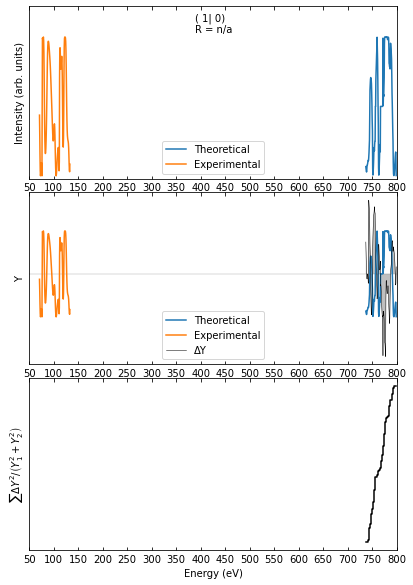

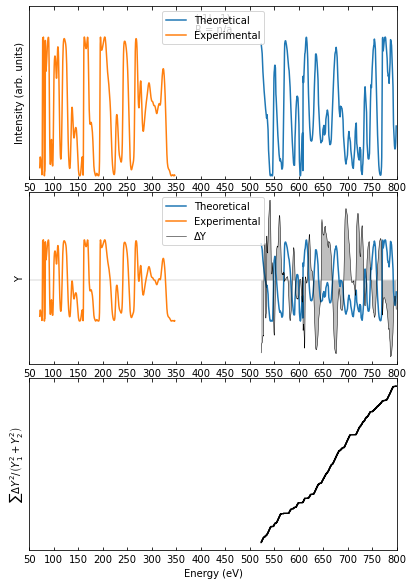

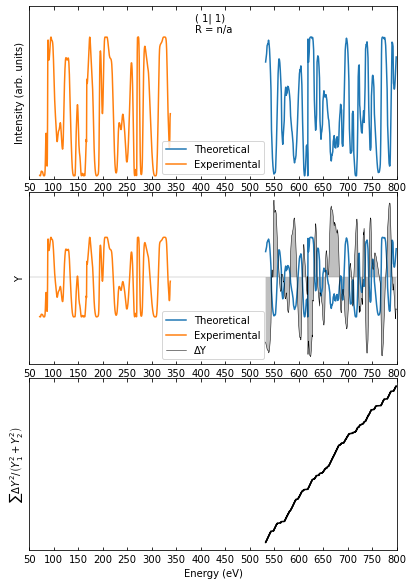

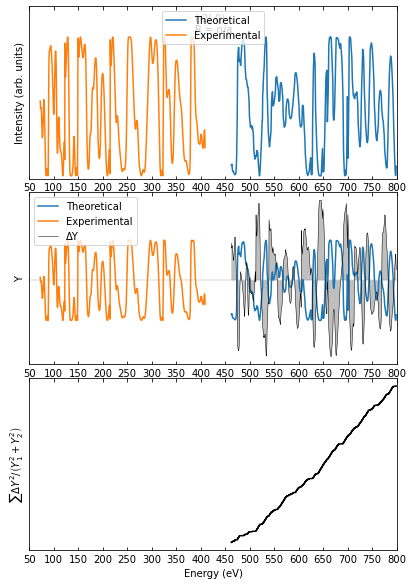

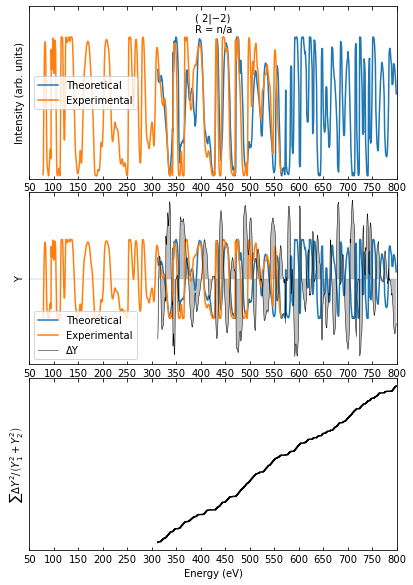

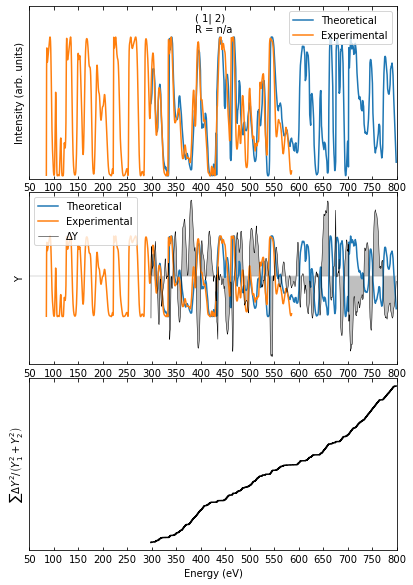

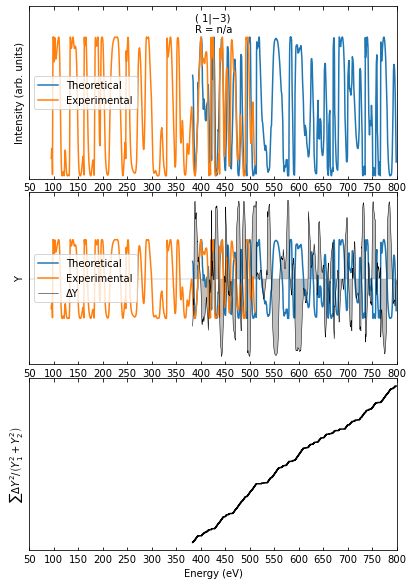

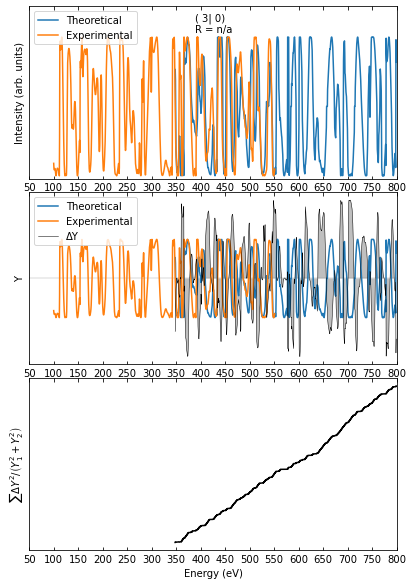

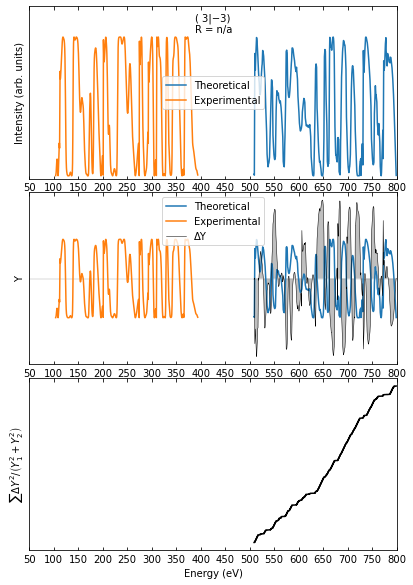

In [17]:
pdf = PdfPages(analysis_name)

figs, figsize, namePos, oritick, plotcolors, rPos, xlims, ylims = prepare_analysis_plot(formatting, exp, theo)

for i in range(len(exp)):
    # Dummy intensity for plotting
    dummy_int = np.copy(exp[i])
    dummy_int[:,0] = 0
    
    size = len(exp[i][:,0])
    theo[i][:,0] += shift
    
    plot_analysis(exp[i][-size:,:], figs, figsize, labels[i], namePos, oritick, plotcolors, rPos, rfact[i], theo[i][-size:,:], xlims, exp[i][-size:,:], ylims, theo[i][-size:,:])



    
for fig in figs:
    pdf.savefig(fig)
    plt.close(fig)
pdf.close()

## Feed the read-in data to new R factor

In [76]:
def get_xy_energy_bounds(exp_xy_list, theo_xy_list):
    min_energy = min(np.min([np.min(xy[:,0]) for xy in exp_xy_list]), np.min([np.min(xy[:,0]) for xy in theo_xy_list]))
    max_energy = max(np.max([np.max(xy[:,0]) for xy in exp_xy_list]), np.max([np.max(xy[:,0]) for xy in theo_xy_list]))
    return min_energy, max_energy
    
def xy_list_to_arrays(xy_list, min_energy, max_energy):
    # make array from xy data
    step = xy_list[1][1,0] - xy_list[1][0,0]

    energies = np.arange(min_energy, max_energy + step, step)
    arr = np.empty([energies.shape[0], len(xy_list)])
    arr[:,:] = np.NaN
    length = len(xy_list)
    id_start = np.empty(length)
    n_beams = np.empty(length)

    for i, xy in enumerate(xy_list):
        e1 = xy[0,0]
        e2 = xy[-1,0]
        start_id = np.where(np.isclose(energies, e1))[0][0]

        arr[start_id:start_id + len(xy[:,1]), i] = xy[:,1]
        id_start[i] = start_id + 1 # Fortran index
        n_beams[i] = len(xy[:,1])
    return energies, arr, step, id_start, n_beams

In [77]:
min_energy, max_energy = get_xy_energy_bounds(exp, theo)

exp_en, exp_arr, exp_step, exp_id_start, exp_nbeams = xy_list_to_arrays(exp, min_energy, max_energy)
theo_en, theo_arr, theo_step, theo_id_start, theo_nbeams = xy_list_to_arrays(theo, min_energy, max_energy)

In [78]:
from rfactor import r_factor_new as rf
from interpolation import interpolation as intpol

In [79]:
rf.r_pendry_beamset_y(exp_step, exp_arr, theo_arr, exp_id_start, theo_id_start, exp_nbeams, theo_nbeams, v0r_shift =1)

(0.33894463180302054,
 array([0.36935932, 0.20381759, 0.10024883, 0.10507004, 0.20619726,
        0.14069121, 0.19555994, 0.39571227, 0.12482881, 0.20670034,
        0.14807532, 0.25970426, 0.18448059, 0.27490919, 0.23617165,
        0.26606968, 0.31554282, 0.3363171 , 0.41537083, 0.27495871,
        0.38061827, 0.37086707, 0.45187339, 0.26804578, 0.64420422,
        0.23273761, 0.2838865 , 0.30705342, 0.41198212, 0.48569873,
        0.25217995, 0.4215403 , 0.42029666, 0.35304994, 0.39966046,
        0.32747133, 0.86728574, 0.40867359, 0.44494559, 0.55689331,
        0.40409455, 0.4107394 , 0.47016037, 0.4943539 , 0.52880259,
        0.5541831 , 0.69200186, 0.8518606 , 0.22657641, 0.50752565,
        0.47247815, 0.45771413, 0.51659663, 0.2245998 , 0.55948487,
        0.56450762, 0.63642323]),
 array([0.24469096, 0.54160938, 0.30700788, 0.41163292, 1.05173911,
        0.70320651, 1.1492679 , 2.24372525, 0.50604004, 1.10387225,
        0.19539033, 1.18425752, 0.47535665, 1.08531264, 1.30

In [84]:
theo_id_start

array([  1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   7.,   7.,  25.,
        25.,  37.,  37.,  49.,  61.,  61.,  61.,  61.,  73.,  73.,  91.,
        91., 127., 127., 133., 133., 145., 145., 157., 163., 163., 169.,
       169., 199., 199., 217., 217., 223., 223., 229., 229., 253., 253.,
       277., 277.])

In [85]:
np.savetxt("tenserleed_y_exp.csv", exp_arr, delimiter = ",")
np.savetxt("tenserleed_y_theo.csv", theo_arr, delimiter = ",")

In [86]:
np.savetxt("tenserleed_exp_id_start.csv", exp_id_start, delimiter = ",")
np.savetxt("tenserleed_theo_id_start.csv", theo_id_start, delimiter = ",")

np.savetxt("tenserleed_exp_n_beams.csv", exp_nbeams, delimiter = ",")
np.savetxt("tenserleed_theo_n_beams.csv", theo_nbeams, delimiter = ",")



           

In [87]:
np.savetxt("tenserleed_energy.csv", exp_en, delimiter = ",")

In [88]:
rf.r_pendry_beamset_y(theo_step, theo_arr, theo_arr, theo_id_start, theo_id_start, theo_nbeams, theo_nbeams, v0r_shift =0)




(0.0,
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.]),
 array([8.84202023, 6.63453897, 6.9228145 , 7.36782082, 6.81299989,
        6.70765526, 9.52347171, 9.05968932, 8.4636936 , 7.63586416,
        6.13443845, 5.75053798, 7.77399247, 5.71648093, 9.1853245 ,
        7.10943012, 6.78512634, 9.66189821, 8.9189777 , 8.60878684,
        8.76965032, 7.41630042, 6.44964457, 9.38644921, 8.4441265 ,
        7.32569418, 6.97087965, 6.74978043, 7.81928575, 8.29840758,
        7.02170671, 6.50046847, 6.82446862, 7.01406694, 6.3892

In [89]:
theo_arr

array([[-0.09419, -0.07685, -0.08239, ...,      nan,      nan,      nan],
       [-0.09297, -0.07965, -0.07888, ...,      nan,      nan,      nan],
       [-0.09141, -0.08233, -0.07533, ...,      nan,      nan,      nan],
       ...,
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan]])

In [60]:
def pendry_r(arr1, arr2, start1, start2, n1, n2):
    
    numerator = np.trapz((arr1[start1 -1 : start1 + n1 -1] - arr2[start2 -1 : start2 + n2 -1])**2)
    denominator = np.trapz(arr1[start1 -1 : start1 + n1 -1]**2 + arr2[start2 -1 : start2 + n2 -1]**2)
    R = numerator/denominator
    return R, numerator, denominator

In [61]:
pendry_r(exp_arr[i], theo_arr[i], int(exp_id_start[i]), int(theo_id_start[i]), int(exp_nbeams[i]), int(theo_nbeams[i]))

/var/folders/fv/bxt6sbpd2sn0kbhr1rksclxc0000gp/T/ipykernel_61416/2574893785.py:5: RuntimeWarning: invalid value encountered in double_scalars
  R = numerator/denominator


(nan, 0.0, 0.0)

In [14]:
exp_id_start

array([1.000e+00, 2.000e+00, 2.000e+00, 4.000e+00, 1.600e+01, 2.900e+01,
       4.900e+01, 5.900e+01, 6.700e+01, 6.600e+01, 1.710e+02, 1.670e+02,
       2.210e+02, 2.220e+02, 2.260e+02, 2.660e+02, 2.630e+02, 3.510e+02,
       3.640e+02, 3.690e+02, 3.660e+02, 4.320e+02, 4.260e+02, 4.780e+02,
       4.820e+02, 5.210e+02, 5.450e+02, 5.510e+02, 5.520e+02, 5.500e+02,
       6.080e+02, 5.880e+02, 6.530e+02, 6.600e+02, 8.200e+02, 7.900e+02,
       8.150e+02, 8.090e+02, 8.280e+02, 8.540e+02, 8.950e+02, 9.560e+02,
       9.100e+02, 9.280e+02, 9.340e+02, 1.043e+03, 1.042e+03, 1.159e+03,
       1.067e+03, 1.162e+03, 1.107e+03, 1.213e+03, 1.133e+03, 1.237e+03,
       1.209e+03, 1.377e+03, 1.300e+03])

In [48]:
for i in range(57):
    print(rf.r_pendry_beam_y(0.5, exp_arr[:,i], theo_arr[:,i], exp_id_start[i], theo_id_start[i], exp_nbeams[i], theo_nbeams[i], v0r_shift =0))


(0.29336001389272065, 0.19614799226600002, 0.6686255214650001, 125)
(0.22659285594682285, 0.6019090870425512, 2.6563462670853495, 552)
(0.12437550597716705, 0.38069684686921124, 3.060866718717911, 534)
(0.11397188903305924, 0.44638075009924477, 3.916586395876666, 674)
(0.21157158742491608, 1.0803053160240523, 5.106098267601448, 974)
(0.15160095018509556, 0.7570961772889648, 4.994006807771299, 1002)
(0.20212507531252036, 1.1875592829645616, 5.875368412990765, 832)
(0.4195404843435981, 2.380359634228524, 5.673730481464194, 903)
(0.13948327391396242, 0.5649006561820418, 4.049952659775465, 581)
(0.2268028445804477, 1.2114064098358441, 5.34123111232035, 955)
(0.18383480677474695, 0.2419634564227934, 1.3162004555495934, 303)
(0.2659645858340406, 1.2131946325026213, 4.56148937535482, 1010)
(0.21164290900536137, 0.545161696674565, 2.5758561873705625, 447)
(0.2749320275686768, 1.0853748383779505, 3.9477933799721776, 972)
(0.2393898041410614, 1.3209856351858131, 5.518136580317418, 902)
(0.278088

In [15]:
theo_arr[1] - exp_arr[1]

NameError: name 'theo_arr' is not defined

In [43]:
%matplotlib osx
plt.plot(exp_arr[:,2])
plt.plot(theo_arr[:,2])

In [36]:
exp_arr[:,2].shape

(1458,)

In [41]:
np.isnan(exp_arr[:,2])

array([ True, False, False, ...,  True,  True,  True])

In [53]:
exp_arr[int(exp_id_start[2]) -1 : int(exp_id_start[2]) -1 + int(exp_nbeams[2]),2].dump("exp_beam_3")
theo_arr[int(theo_id_start[2]) -1 : int(theo_id_start[2]) -1 + int(theo_nbeams[2]),2].dump("theo_beam_3")

In [57]:
exp_id_start

array([1.000e+00, 2.000e+00, 2.000e+00, 4.000e+00, 1.600e+01, 2.900e+01,
       4.900e+01, 5.900e+01, 6.700e+01, 6.600e+01, 1.710e+02, 1.670e+02,
       2.210e+02, 2.220e+02, 2.260e+02, 2.660e+02, 2.630e+02, 3.510e+02,
       3.640e+02, 3.690e+02, 3.660e+02, 4.320e+02, 4.260e+02, 4.780e+02,
       4.820e+02, 5.210e+02, 5.450e+02, 5.510e+02, 5.520e+02, 5.500e+02,
       6.080e+02, 5.880e+02, 6.530e+02, 6.600e+02, 8.200e+02, 7.900e+02,
       8.150e+02, 8.090e+02, 8.280e+02, 8.540e+02, 8.950e+02, 9.560e+02,
       9.100e+02, 9.280e+02, 9.340e+02, 1.043e+03, 1.042e+03, 1.159e+03,
       1.067e+03, 1.162e+03, 1.107e+03, 1.213e+03, 1.133e+03, 1.237e+03,
       1.209e+03, 1.377e+03, 1.300e+03])